In [6]:
import os 
wdir = os.getcwd()
print(wdir)

/home/bryan1010/tutorials/bioinfo


In [7]:
#pip install Bio
from Bio import SeqIO
from Bio import Entrez

### 1. Sequences Retrieval

In [8]:
#Save nucleotide sequence in fasta format

Entrez.email = "bryan@gmail.com"

# Fetching the Genbank Format under Nucleotide Database with Accession id = "MT747438"
with Entrez.efetch(db = "nucleotide", rettype="gb", retmode="text",
id="MT747438") as handle:
    for record in SeqIO.parse(handle,"gb"):
        print(record.description)
        print(record.seq)
        nuc_des = str(record.description)
        nuc_seq = str(record.seq)


#Generate Text File
f = open("BE_isolate.txt","w+")
f.write(">" + nuc_des + "\n" + nuc_seq + "\n")
f.close()

Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/Felis catus/BEL/BE-MG-0320/2020, complete genome
AGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTACTGTCGTTGACAGGACACGAGTAACTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGCAGCCGATCATCAGCACATCTAGGTTTTGTCCGGGTGTGACCGAAAGGTAAGATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAACTCAGTTTGCCTGTTTTACAGGTTCGCGACGTGCTCGTACGTGGCTTTGGAGACTCCGTGGAGGAGGTCTTATCAGAGGCACGTCAACATCTTAAAGATGGCACTTGTGGCTTAGTAGAAGTTGAAAAAGGCGTTTTGCCTCAACTTGAACAGCCCTATGTGTTCATCAAACGTTCGGATGCTCGAACTGCACCTCATGGTCATGTTATGGTTGAGCTGGTAGCAGAACTCGAAGGCATTCAGTACGGTCGTAGTGGTGAGACACTTGGTGTCCTTGTCCCTCATGTGGGCGAAATACCAGTGGCTTACCGCAAGGTTCTTCTTCGTAAGAACGGTAATAAAGGAGCTGGTGGCCATAGTTACGGCGCCGATCTAAAGTCATTTGACTTAGGCGACGAGCTTGGCACTGATCCTTATGAAGATTTTCAAGAAAACTGGAACACTAAACATAGCAGTGGTGTTACCCGTGAACTCATGCGTGAGCTTAACGGAGGGGCATACACTCGCTATGTCGATAACAACTTCTGTGGCCCTGATGGCTACCCTCTTGAGTGCATTAAAGACCTTCTAGCACGTGCTGGTAAAGCTTCATGCACTTTGTCCGAACAACTGGACTTTATTGACACTA

### 2. Calculate the length of a PCR Fragment

In [9]:
f = open("BE_isolate.txt")
BE_isolate = f.read()
#BE_isolate = str(BE_isolate)

from Bio.Seq import Seq

fwp = str(Seq("TGTCCGAACAACTGGACTTT"))  #Forward Primer
rvp = Seq("ACTCCACTCATCTAAATCAA") #Reverse Primer
rvp_rc = str(rvp.reverse_complement())
# print(rvp_rc)

match = BE_isolate.find(fwp)
match2 = BE_isolate.find(rvp_rc)

print("The expected length of the PCR fragment is", match2-match+len(fwp)," bp.")
print("The length between the two primers is", match2-match-len(rvp), " bp.")


The expected length of the PCR fragment is 2060  bp.
The length between the two primers is 2020  bp.


### 3. Basic Local Alignment Sequence Tool (BLAST)

First step is to obtain BLAST results from the NCBI Database

In [29]:
from Bio.Blast import NCBIWWW
result_handle = NCBIWWW.qblast("blastn", "nt", "MT747438") 

# Save the results in a file
with open("blast_BE_isolate.xml", "w+") as save_to:
    save_to.write(result_handle.read())
    result_handle.close()

In [ ]:
from Bio.Blast import NCBIXML
result_handle = open("blast_BE_isolate.xml", 'r')
blast_record = NCBIXML.read(result_handle)

E_VALUE_THRESH = 0.0001
ct = 0
for alignment in blast_record.alignments:
    for hsp in alignment.hsps:
        ct += 1
        if hsp.expect < E_VALUE_THRESH:
            print("\n")
            print("****Alignment****")
            print('Sequence: ', alignment.title)
            print('Length: ', alignment.length)
            print('E Value: ', hsp.expect)
            print(hsp.query[0:80] + '...')
            print(hsp.match[0:80] + '...')
            print(hsp.sbjct[0:80] + '...')

print(f"\n There are {ct} sequences in the BLAST output")


 There are 0 sequences in the BLAST output


#### 4. Pairwise Sequence Alignment 

In [14]:
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as pltpy

#Function for the Dot Plot Algorithm
def fillMat(M):
    ct = 0
    M[0][0] = ""
    for r in range(1, M.shape[0]):
        for c in range(1, M.shape[1]):
            if M[r][0] == M[0][c]:
                M[r][c] = "*"
                if r == c:
                    ct += 1
            else:
                M[r][c] = " "
    incorr = M.shape[0] - ct - 1
    print(f"Number of aligned bases: {ct}")
    print(f"Number of unaligned bases: {incorr} \n")


def fill_print():
    D = np.zeros([len(sequence1)+1,len(sequence2)+1],dtype=str)
    for r in range(0, len(sequence1)):
        D[r + 1][0] = sequence1[r:r+1]
    for c in range(0, len(sequence2)):
        D[0][c + 1] = sequence2[c:c+1]
    fillMat(D)
    print(D)

def fill_plot():
    D = np.zeros([len(sequence1)+1, len(sequence2)+1],dtype=str)
    # print(D), print(D.shape[0])
    for r in range(0, len(sequence1)):
        D[r+1][0] = sequence1[r:r+1]
    for c in range(0, len(sequence2)):
        D[0][c+1] = sequence2[c:c+1]
    fillMat(D)

    cmap = plt.colors.ListedColormap(['dodgerblue','white'])
    bounds = [0, 0.5, 1]
    norm = plt.colors.BoundaryNorm(bounds, cmap.N)

    fig, ax = pltpy.subplots(figsize=(10,10),dpi=70)
    D_red = np.delete(D, 0, axis = 1)
    D_red = np.delete(D, 0, axis = 0)
    D_red_log = D_red == "*"
    ax.imshow(D_red_log,cmap=cmap,norm=norm)


Test those functions with small examples

In [15]:
#Fill_Print Method
sequence1 = "GAGATTACAGATTACAT"
sequence2 = "TACCATTHHATTACAGT"

fill_print()

Number of aligned bases: 4
Number of unaligned bases: 13 

[['' 'T' 'A' 'C' 'C' 'A' 'T' 'T' 'H' 'H' 'A' 'T' 'T' 'A' 'C' 'A' 'G' 'T']
 ['G' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' '*' ' ']
 ['A' ' ' '*' ' ' ' ' '*' ' ' ' ' ' ' ' ' '*' ' ' ' ' '*' ' ' '*' ' ' ' ']
 ['G' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' '*' ' ']
 ['A' ' ' '*' ' ' ' ' '*' ' ' ' ' ' ' ' ' '*' ' ' ' ' '*' ' ' '*' ' ' ' ']
 ['T' '*' ' ' ' ' ' ' ' ' '*' '*' ' ' ' ' ' ' '*' '*' ' ' ' ' ' ' ' ' '*']
 ['T' '*' ' ' ' ' ' ' ' ' '*' '*' ' ' ' ' ' ' '*' '*' ' ' ' ' ' ' ' ' '*']
 ['A' ' ' '*' ' ' ' ' '*' ' ' ' ' ' ' ' ' '*' ' ' ' ' '*' ' ' '*' ' ' ' ']
 ['C' ' ' ' ' '*' '*' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' '*' ' ' ' ' ' ']
 ['A' ' ' '*' ' ' ' ' '*' ' ' ' ' ' ' ' ' '*' ' ' ' ' '*' ' ' '*' ' ' ' ']
 ['G' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' '*' ' ']
 ['A' ' ' '*' ' ' ' ' '*' ' ' ' ' ' ' ' ' '*' ' ' ' ' '*' ' ' '*' ' ' ' ']
 ['T' '*' ' ' ' ' ' ' ' ' '*' '*' ' ' ' ' 

Number of aligned bases: 4
Number of unaligned bases: 13 



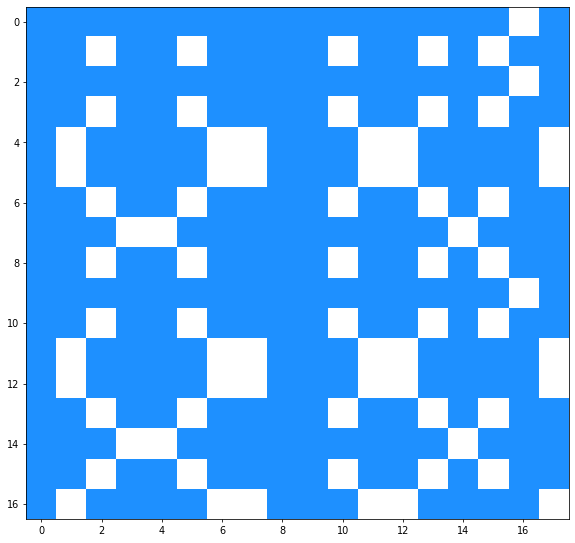

In [16]:
#Fill_Plot Method
sequence1 = "GAGATTACAGATTACAT"
sequence2 = "TACCATTHHATTACAGT"

fill_plot()

Try an actual example by retrieving sequences from NCBI

In [11]:
#Getting Two Sequences
import csv
import os
from Bio import SeqIO
from Bio import Entrez

Entrez.email = "bryan@gmail.com"

fasta_file = {}
with open('try.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        with Entrez.efetch(db="nucleotide",rettype="gb",retmode="text",id=row[0]) as handle:
            for seq_record in SeqIO.parse(handle,"gb"):
                fasta_file[row[1]] = str(seq_record.seq)

for title, seq in fasta_file.items():
    download_path = os.path.join("ncbi_downloads",f"{title}.txt")
    with open(download_path,'w') as file:
        file.write(seq)

In [18]:
be = open("ncbi_downloads/Belgium.txt","r")
besr = be.read()
sequence1 = besr[1000:2000]
be.close()

ch = open("ncbi_downloads/Chile.txt","r")
chsr = ch.read()
sequence2 = chsr[1000:2000]
ch.close()

Number of aligned bases: 1000
Number of unaligned bases: 0 



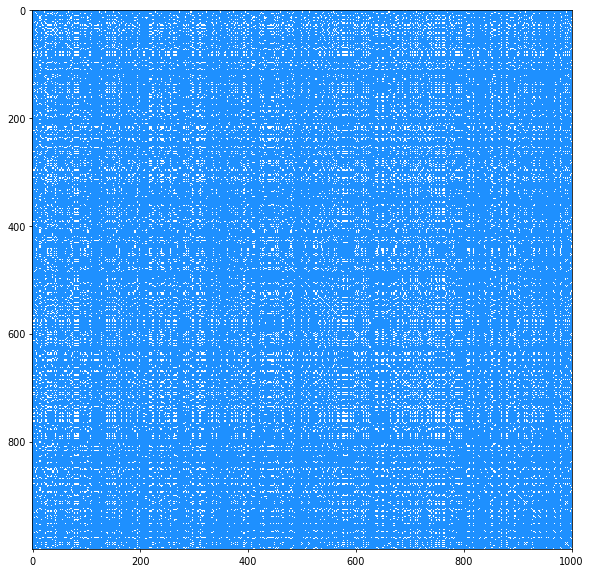

In [19]:
fill_plot()

#### 5. Phylogenetic Tree

In [22]:
# Ensure the working directory
import os 
wdir = os.getcwd()
print(wdir)

/home/bryan1010/tutorials/bioinfo


In [21]:
import csv
from Bio import SeqIO
from Bio import Entrez

fasta_file = {}
ct = 0

Entrez.email = "bryan@gmail.com"
with open('accessions.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        print(row)
        with Entrez.efetch(db="nucleotide", rettype="gb", retmode = "text", id = row[0]) as handle:
            for seq_record in SeqIO.parse(handle, "gb"):
                fasta_file[row[1]] = str(seq_record.seq)
                ct += 1  
      
print("Number of sequences in file:", ct)

# save all sequences in the multi-fasta file "sequences_general.txt"

f = open("sequences.txt","w+")
for keys,values in fasta_file.items():
    f.write(">" + str(keys) + "\n" + str(values) + "\n")
f.close()

['MT905416', 'Egypt']
['MT890204', 'Ghana']
['MT872492', 'Sierra-Leone']
['MT576584', 'Nigeria']
['MT549878', 'Kenya']
['NC_045512', 'China']
['MT876526', 'Bangladesh']
['LC573284', 'Japan']
['MT825091', 'Iran']
['MT820472', 'Saudi-Arabia']
['MT479216', 'Italy']
['MT890462', 'Russia']
['MT704821', 'Germany']
['MT747438', 'Belgium']
['MT328032', 'Greece']
['MT966087', 'USA(FL)']
['MT810770', 'Mexico']
['MT276328', 'USA(OR)']
['MT263422', 'USA(WA)']
['MT821624', 'USA(WA2)']
['MT007544', 'Australia(Melbourne)']
['MT612216', 'Australia(Victoria)']
['MT451211', 'Australia(Victoria2)']
['MT459987', 'Guam']
['MT706050', 'New-Zealand ']
['MT835383', 'Brazil']
['MT670021', 'Chile']
['MT907518', 'Venezuela']
['MT263074', 'Peru']
['MT670014', 'Chile2']
Number of sequences in file: 30


Multiple Sequence Alignment(MSA)

In [25]:
from Bio.Align.Applications import ClustalOmegaCommandline

in_file = "sequences.txt"
out_file = "alignment_covid_general.fasta"

clustalomega_cline = ClustalOmegaCommandline(infile = in_file, outfile= out_file, verbose=True,
auto = False)
print(clustalomega_cline)

clustalo -i sequences.txt -o alignment_covid_general.fasta -v


In [26]:
"""
# WINDOWS
# Python will fill out clustal omega in the command line for you!
path = "r'" + str(wdir) #.'
input_command = '"' + wdir + '/clustal-omega-1.2.2-win64/' + str(clustalomega_cline)[0:8] + '" ' + str(clustalomega_cline)[9:] + '-threads=1'
os.system(input_command)

"""
# MAC
# Python will fill out clustal omega in the command line for you!
input_command = "./" + str(clustalomega_cline)
os.system(input_command)

sh: 1: /home/bryan1010/tutorials/bioinfo/clustal-omega-1.2.2-win64/clustalo: not found


32512

Preparing the Phylogenetic Tree

In [ ]:
out_file = "alignment_covid.fasta"

# Read alignment file
from Bio import AlignIO
align = AlignIO.read(out_file, "fasta")
print(align)

# Calculate distance matrix
from Bio.Phylo.TreeConstruction import DistanceCalculator
calculator = DistanceCalculator('identity')
dm = calculator.get_distance(align)
print(dm)

Drawing the Tree Using Matplotlib

In [ ]:
from Bio import Phylo
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
constructor = DistanceTreeConstructor()
tree = constructor.upgma(dm)

import matplotlib
import matplotlib.pyplot as plt

def plot_tree(tree, output_file):
    # set the size of the figure
    fig = plt.figure(figsize=(50, 40), dpi=100)
    # fig.set_size_inches(10, 20) # in inches
    plt.rcParams.update({'font.size':30})
    axes = fig.add_subplot(1, 1, 1)
    fig1 = plt.gcf()
    Phylo.draw(tree, axes=axes, branch_labels=None)
    Phylo.draw_ascii(tree)
    fig1.savefig(output_file, dpi=100)
    return

plot_tree(tree,"tree.jpg")